In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from notebook_utils import get_distribution_over_vocabulary, get_mlm_results, get_downstream_results
from scipy.spatial.distance import jensenshannon

import itertools


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
FIGURE_DIR = "/home/limisiewicz/my-luster/entangled-in-scripts/output/figures"
TABLE_DIR =  "/home/limisiewicz/my-luster/entangled-in-scripts/output/tables"

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 18

## Parameters

In [6]:
name_map = {
    '20l-multilingual': 'Unigram',
    '20l-bpe': 'BPE',
    '20l-merged': 'TokMix'
}

In [7]:
languages = ("ar", "tr", "zh", "el", "es", "en", "sw", "hi", "mr", "ur", "ta", "te", "th", "ru", "bg", "he", "ka", "vi", "fr", "de")
languages_by_script = ("zh", "he", "ka", "ar", "ur", "hi", "mr", "ta", "te", "th", "el","ru", "bg", "sw", "vi","tr", "fr", "de", "es", "en")
languages_pos = ("zh", "he", "ar", "ur", "hi", "mr", "ta", "te", "el","ru", "bg", "vi","tr", "fr", "de", "es", "en")
languages_xnli = ("zh", "ar", "ur", "hi", "th", "el","ru", "bg", "sw", "vi","tr", "fr", "de", "es", "en")


same_script = list(itertools.permutations(("ar", "ur"),2)) + \
              list(itertools.permutations(("ur", "mr"),2)) + \
              list(itertools.permutations(("ru", "bg"),2)) + \
              list(itertools.permutations(("sw", "vi","tr", "fr", "de", "es", "en"),2))

n_lang_pairs = len(languages) * (len(languages) - 1)
n_lang_pairs_ss = len(same_script)

alpha = 0.25
tokenization_types = ('20l-multilingual', '20l-merged', '20l-bpe')
N_vocab = 120000

ft_type = 'PROBE'

In [8]:
X_lang_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer','diff-script', 'same-script','all'])
X_lang_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer','diff-script', 'same-script','all'])

In [9]:
X_trans_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer','src', 'tgt','value'])
X_trans_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer','src', 'tgt','vlue'])

# Tokenizers and Overlap Usage

In [10]:
vocab_distributions = dict()
vocab_dist_arrays = dict()
vocab_frequencies = dict()

for tok_type in tokenization_types:
    vocab_distributions[tok_type], vocab_frequencies[tok_type] \
        = get_distribution_over_vocabulary(tok_type, alpha, N_vocab, languages)
    vocab_dist_arrays[tok_type] = {lang: np.array(list(vocab_distributions[tok_type][lang].values()))
                                   for lang in languages + ('All',)}

## JSD across tokenizers

Jeensehn Shannon Divergence

In [11]:
jsd = {}

for t_idx, tokenization in enumerate(tokenization_types):
    jsd[tokenization] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        jsd[tokenization][(lang1, lang2)] = jensenshannon(vocab_dist_arrays[tokenization][lang1],
                                                          vocab_dist_arrays[tokenization][lang2], base=2.) ** 2
    

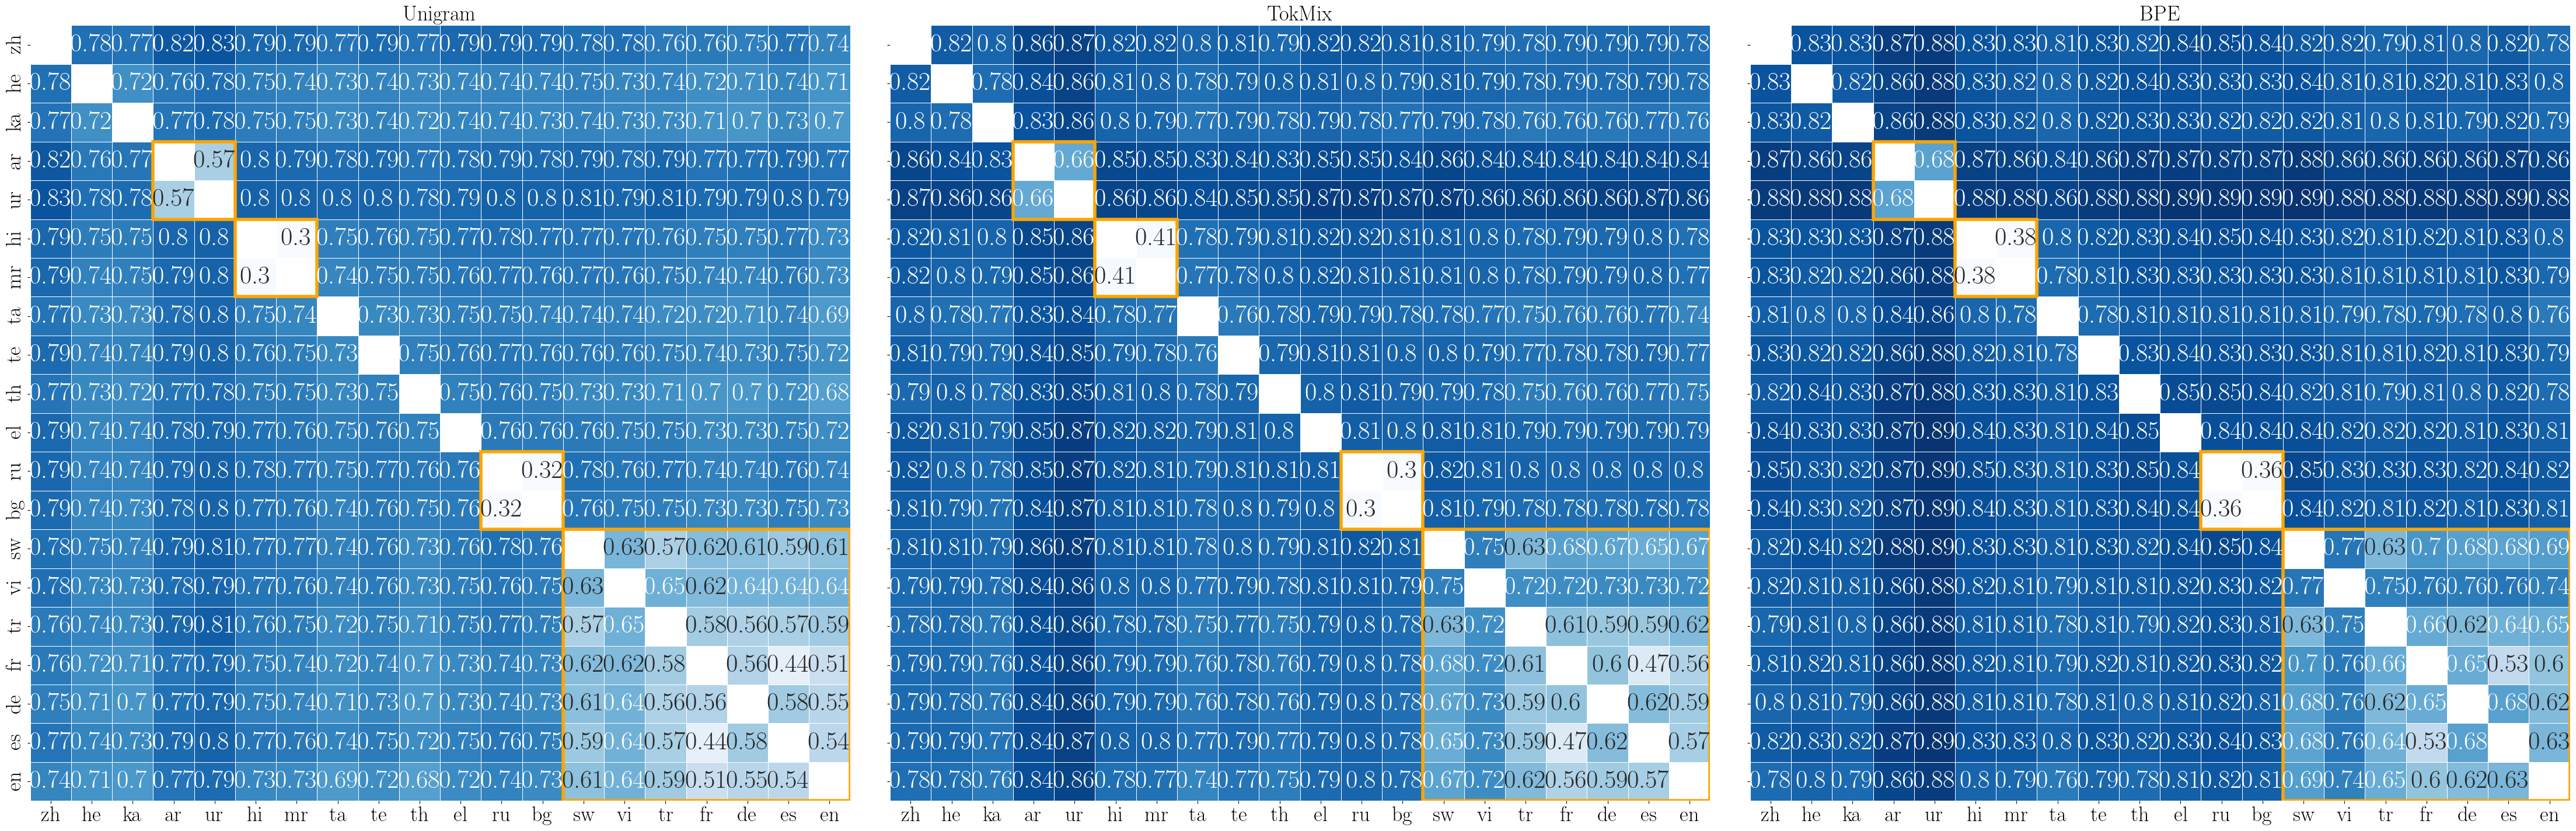

In [12]:
fig, axes = plt.subplots(1, 3,figsize=(45, 15),sharex=True,sharey=True)
axes = axes.ravel()

for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    
    divergences = np.array([[jsd[tokenization][(lang1, lang2)] for lang1 in languages_by_script]
                            for lang2 in languages_by_script])
    mask = np.eye(divergences.shape[0], dtype='bool')
    
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=axes[t_idx], cmap="Blues",
               vmin=0.4, vmax=.9, cbar=False)
    
    axes[t_idx].add_patch(patches.Rectangle(
         (3, 3), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_idx].add_patch(patches.Rectangle(
         (5, 5), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_idx].add_patch(patches.Rectangle(
         (11, 11), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_idx].add_patch(patches.Rectangle(
         (13, 13), 7.0, 7.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    
    axes[t_idx].set_xticks(np.arange(len(languages)) + 0.5, labels=languages_by_script)
    axes[t_idx].set_yticks(np.arange(len(languages)) + 0.5, labels=languages_by_script)
    axes[t_idx].set_title(f"{name_map[tokenization]}")

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "jensehnshannon_d_20L.pdf"), dpi=300)
plt.show()

Average allocation

In [13]:
for tokenization in tokenization_types:
    jsd_est = {'task': 'overlap', 'metric': 'JSD', 'diff-script': 0., 'same-script': 0., 'all': 0.,
                'tokenizer': tokenization} 
    jsd_std = {'task': 'overlap', 'metric': 'JSD', 'diff-script': 0., 'same-script': 0., 'all': 0.,
                'tokenizer': tokenization} 

    for lang1, lang2 in itertools.product(languages, languages):
        if lang1 != lang2:
            jsd_est['all'] += jsd[tokenization][(lang1, lang2)] / n_lang_pairs
            if (lang1, lang2) in same_script:
                jsd_est['same-script'] += jsd[tokenization][(lang1, lang2)]/ n_lang_pairs_ss
            else:
                jsd_est['diff-script'] += jsd[tokenization][(lang1, lang2)] / (n_lang_pairs - n_lang_pairs_ss)
    
            
            X_trans_results = X_trans_results.append({'task': 'overlap', 'metric': 'JSD', 'tokenizer': tokenization, 
                                                      'src': lang1, 'tgt': lang2,
                                                      'value': jsd[tokenization][(lang1, lang2)]}, ignore_index=True)
            X_trans_stds = X_trans_stds.append({'task': 'overlap', 'metric': 'JSD', 'tokenizer': tokenization,
                                                'src': lang1, 'tgt': lang2,
                                                'value': 0.},ignore_index=True)

            

    X_lang_results = X_lang_results.append(jsd_est, ignore_index=True)
    X_lang_stds = X_lang_stds.append(jsd_std, ignore_index=True)

# Results for LMs

## Down-stream cross-lingual transfer (Heatmaps)


POS

In [14]:
pos_results = dict()
pos_stds = dict()

metrics = ('accuracy','f1-macro')
for tok_type in tokenization_types:
    pos_results[tok_type], pos_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages_pos,
                                                                        'POS',ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1230,1231, 1232))


/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/he/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/hi/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/he/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/hi/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenizatio

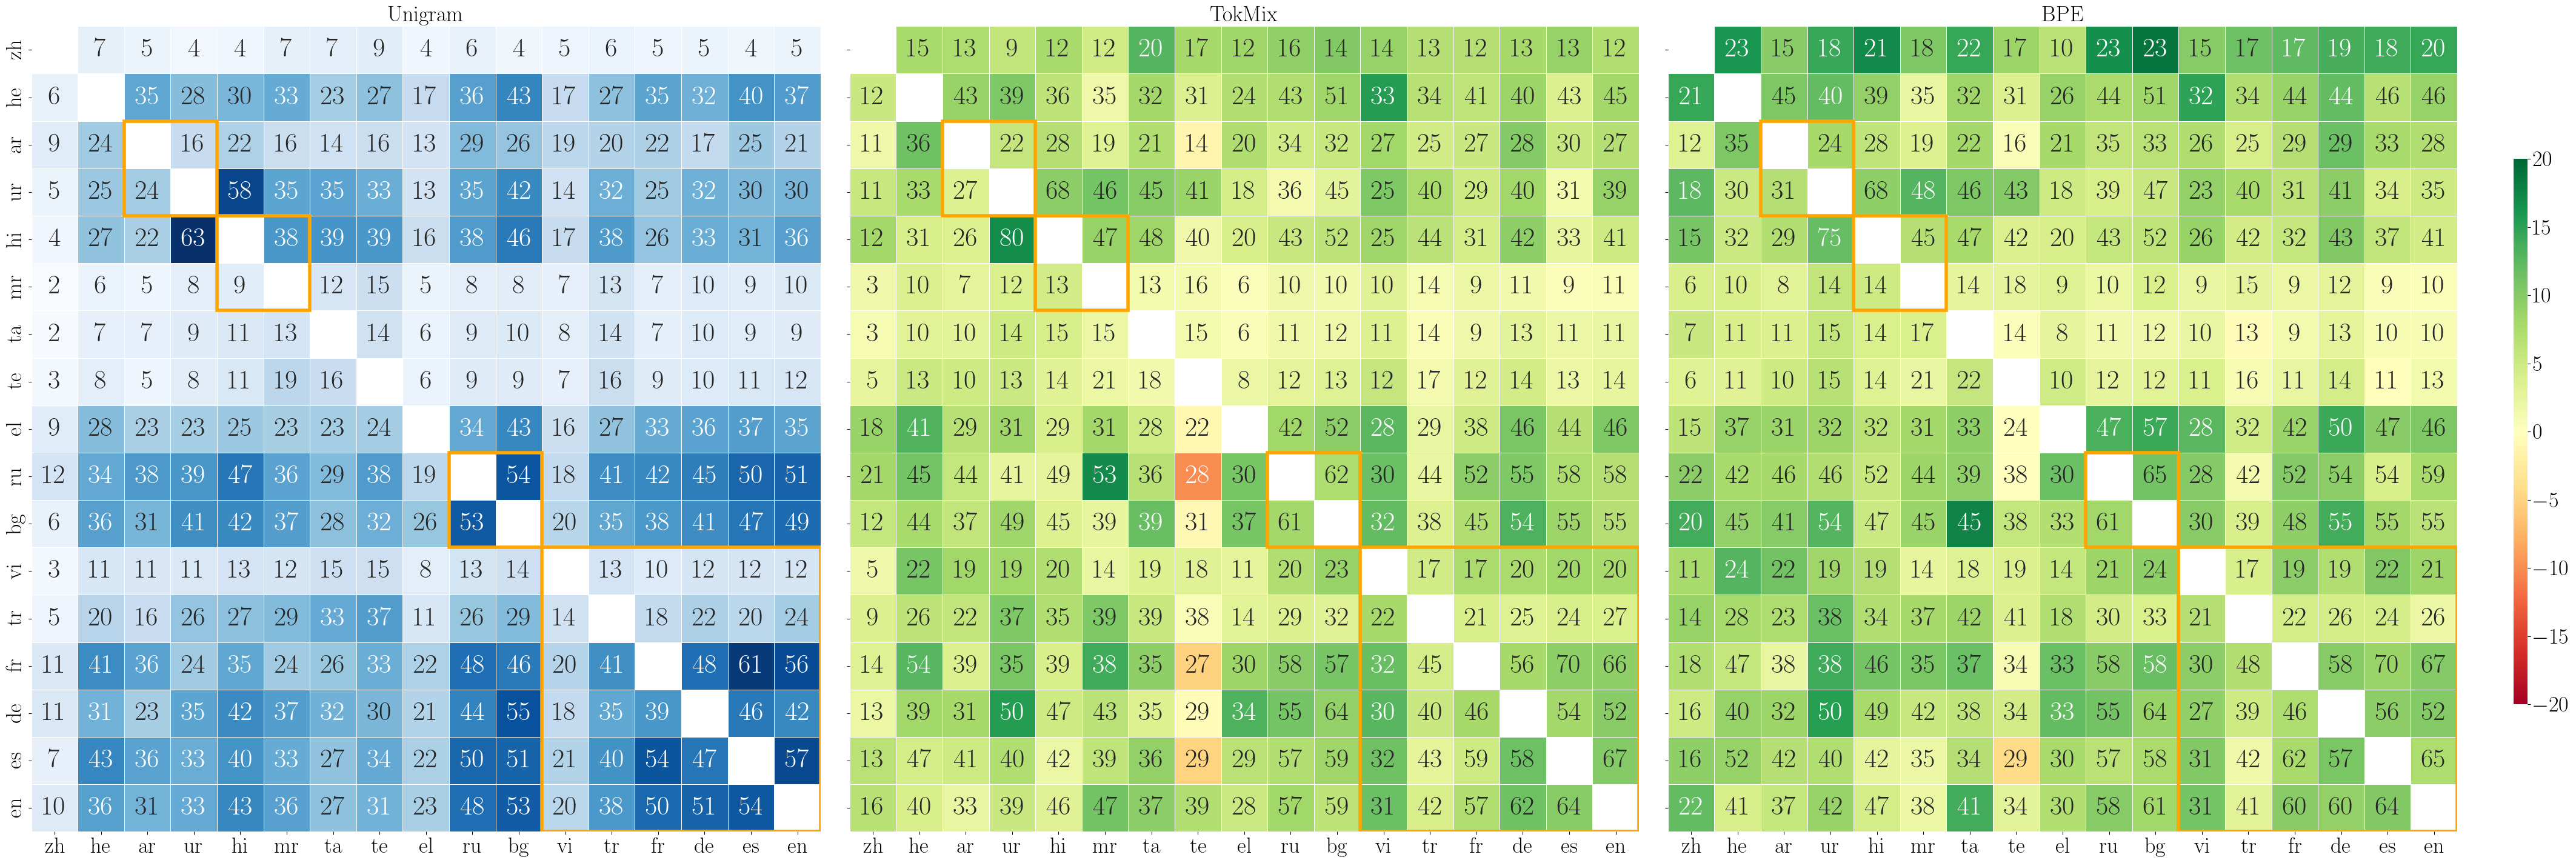

In [15]:
metric = 'f1-macro'
fig, axes = plt.subplots(1, 3,figsize=(45, 15),sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.93, .2, .005, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages_pos), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_pos):
        for jdx, lang2 in enumerate(languages_pos):
            res[idx, jdx] = pos_results[tokenization][metric][lang1][lang2] * 100

    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20, vmax=20,
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)
        

    axes[t_id].add_patch(patches.Rectangle(
         (2, 2), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (4, 4), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (9, 9), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (11, 11), 6.0, 6.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    
    axes[t_id].set_xticks(np.arange(len(languages_pos)) + 0.5, labels=languages_pos)
    axes[t_id].set_yticks(np.arange(len(languages_pos)) + 0.5, labels=languages_pos)
    axes[t_id].set_title(f"{name_map[tokenization]}")

#fig.suptitle("POS F1")
fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "POS_F1_transfer_20l.pdf"), dpi=300)
fig.show()

NER

In [16]:
ner_results = dict()
ner_stds = dict()

metrics = ('f1-seqeval','f1-macro')
for tok_type in tokenization_types:
    ner_results[tok_type], ner_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'NER',ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1230,1231, 1232))


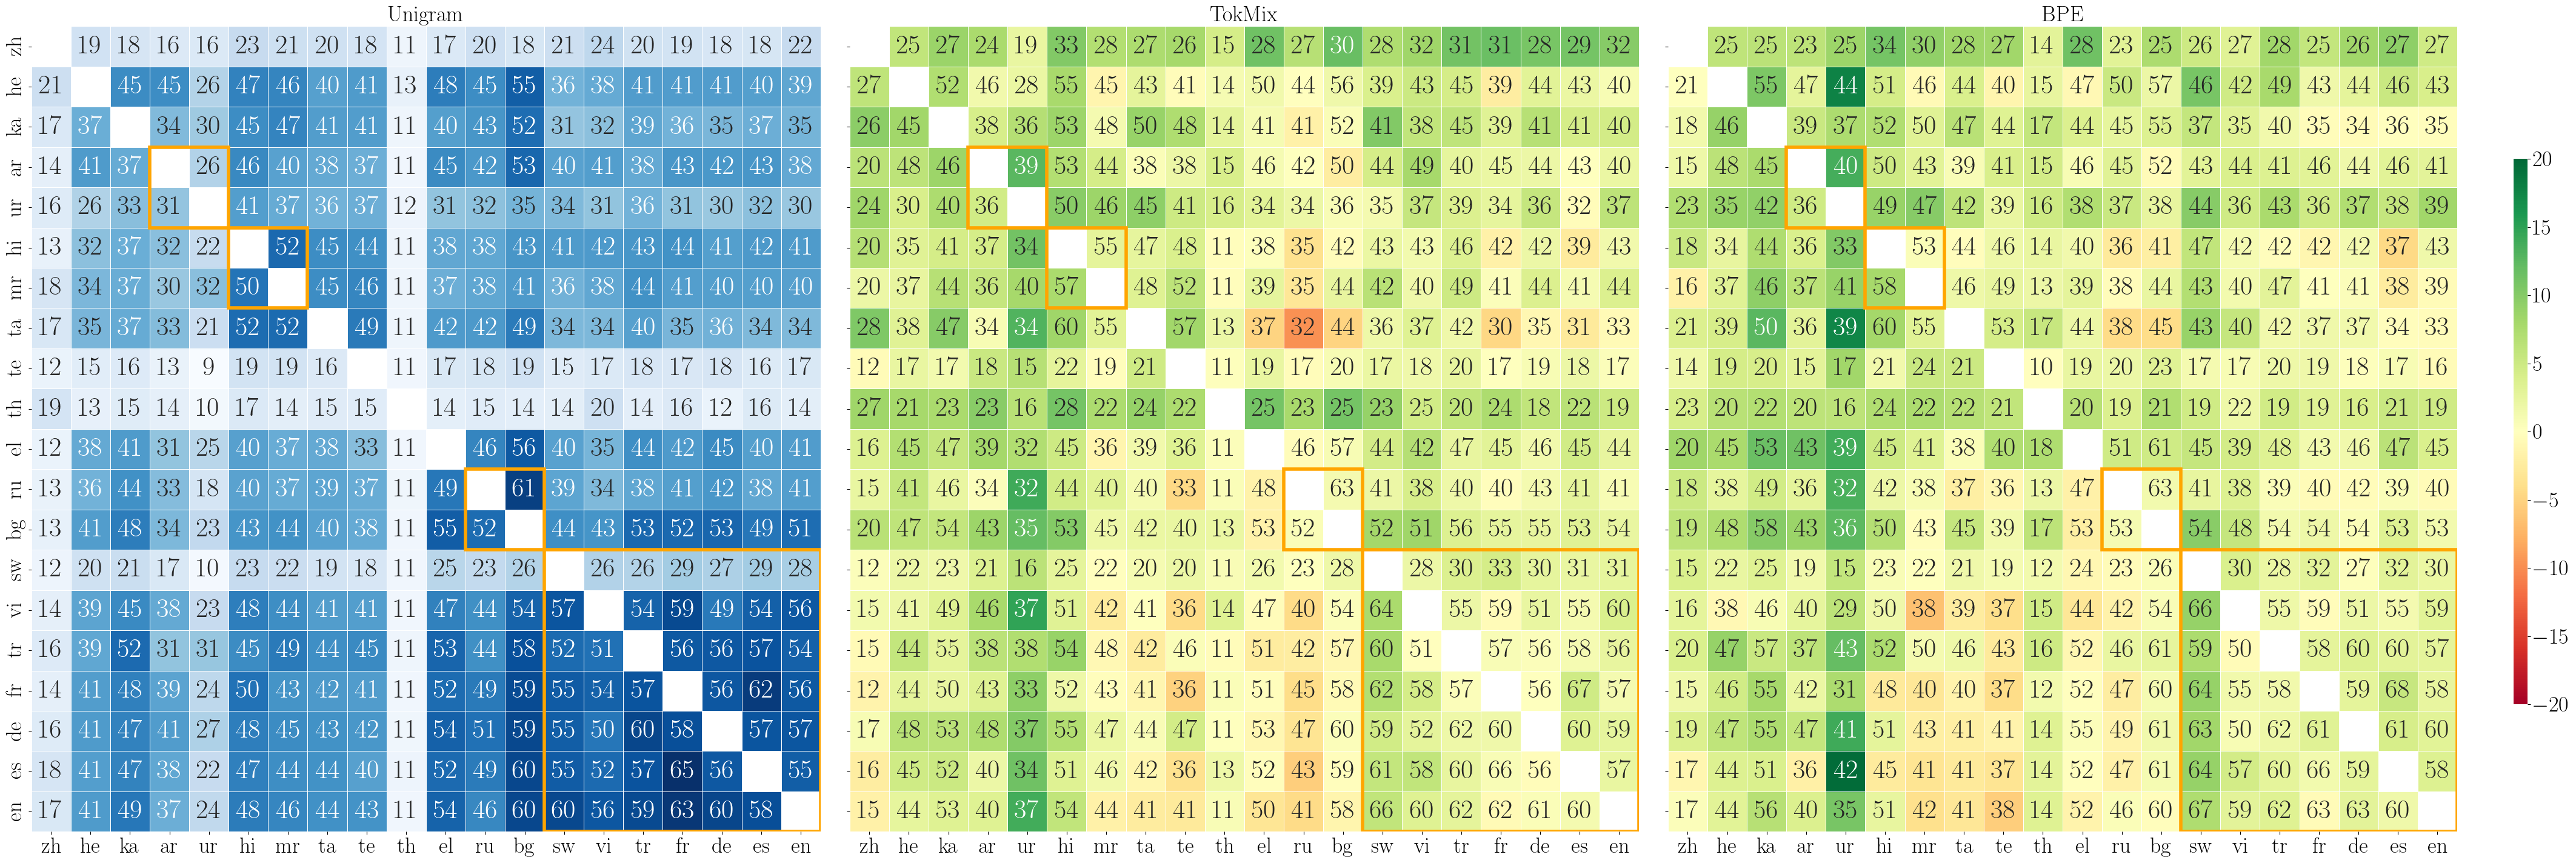

In [17]:
metric = 'f1-macro'
fig, axes = plt.subplots(1, 3,figsize=(45, 15),sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.93, .2, .005, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_by_script):
        for jdx, lang2 in enumerate(languages_by_script):
            res[idx, jdx] = ner_results[tokenization][metric][lang1][lang2] * 100

    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20, vmax=20,
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)
        
    axes[t_id].add_patch(patches.Rectangle(
         (3, 3), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (5, 5), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (11, 11), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (13, 13), 7.0, 7.0,
         edgecolor='orange',fill=False, lw=4
     ) )

    axes[t_id].set_xticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_yticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_title(f"{name_map[tokenization]}")

#fig.suptitle("NER F1")

fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "NER_F1_transfer_20L.pdf"), dpi=300)
fig.show()

XNLI

In [18]:
xnli_results = dict()
xnli_stds = dict()

metrics = ('accuracy',)
for tok_type in tokenization_types:
    xnli_results[tok_type], xnli_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages_xnli,
                                                                        'XNLI', ft_type=ft_type, metrics=metrics,
                                                                        seeds=(2000,2001,2002))

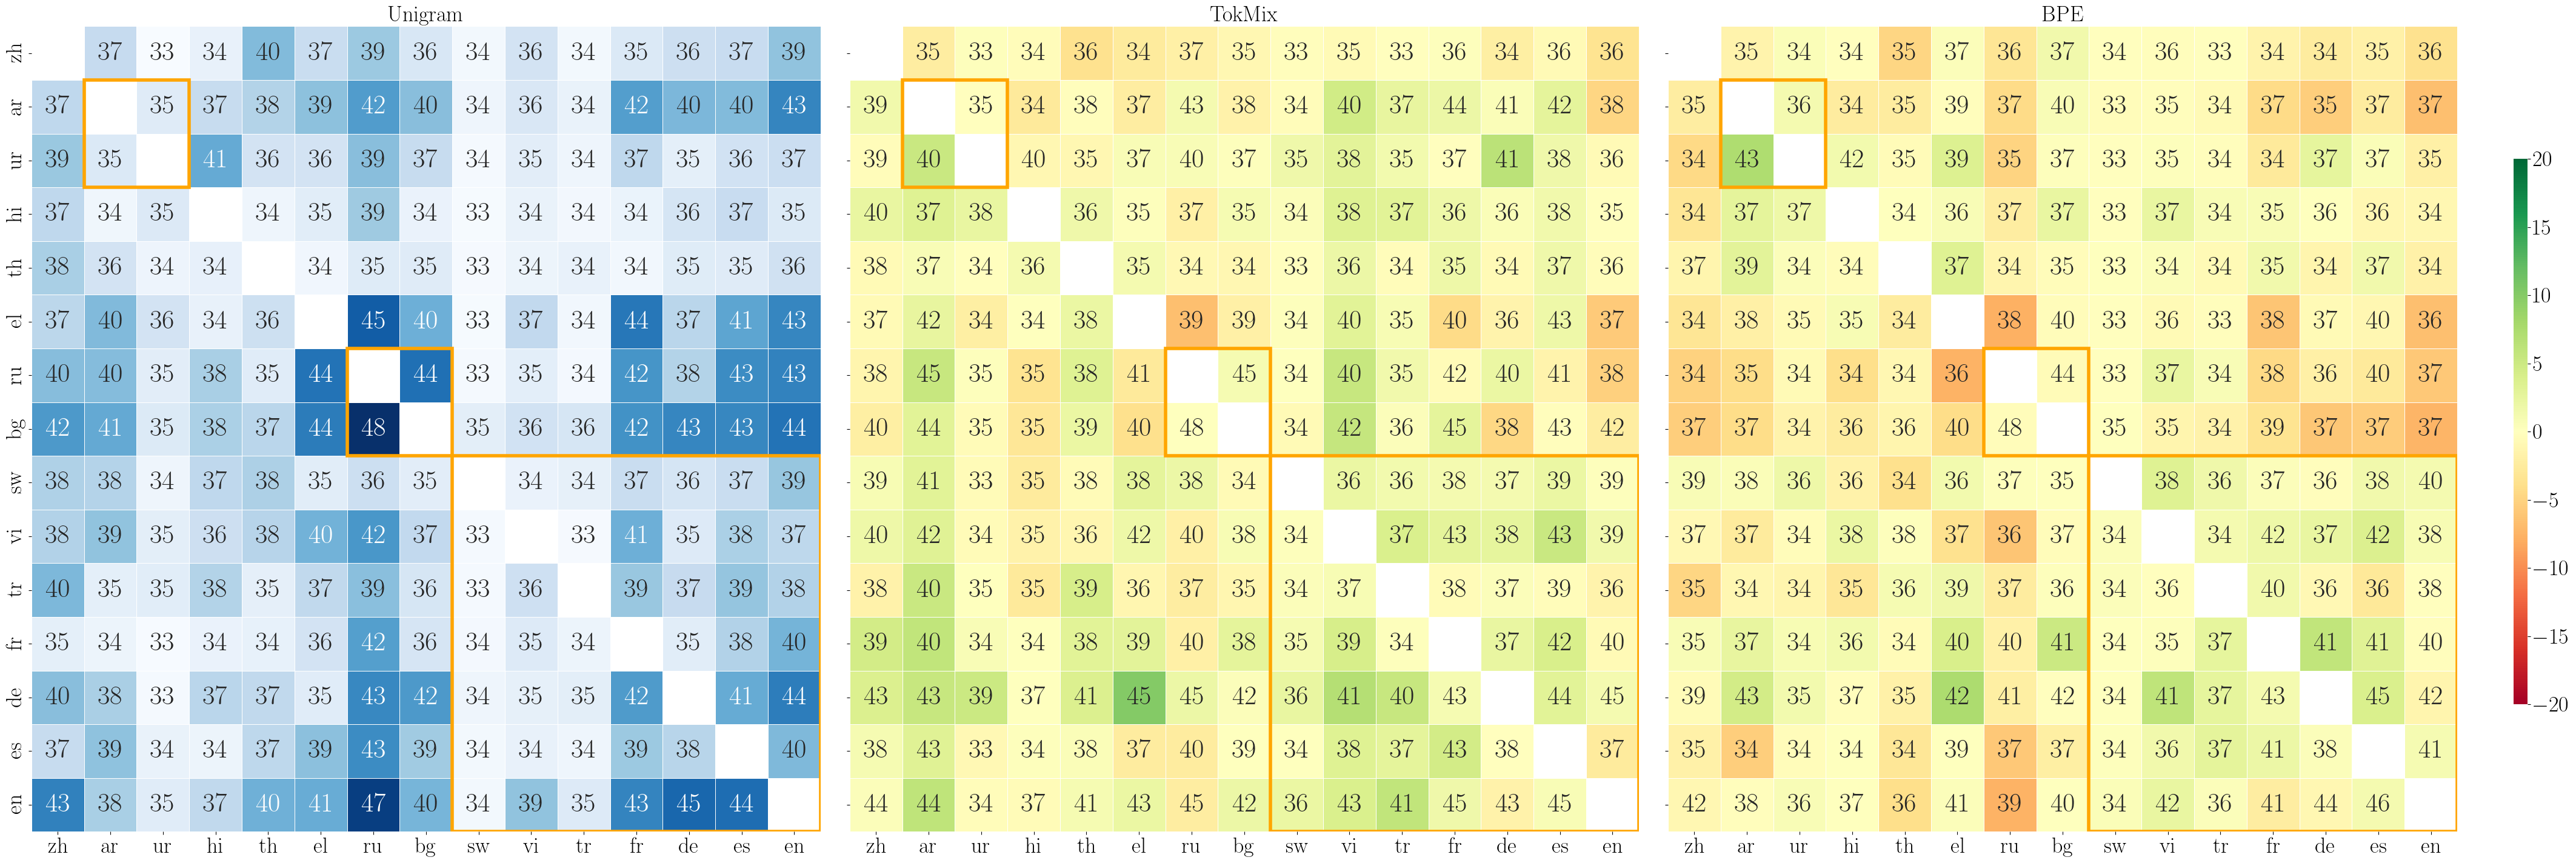

In [19]:
metric = 'accuracy'
fig, axes = plt.subplots(1, 3,figsize=(45, 15),sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.93, .2, .005, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages_xnli), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_xnli):
        for jdx, lang2 in enumerate(languages_xnli):
            res[idx, jdx] = xnli_results[tokenization][metric][lang1][lang2] * 100

    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20, vmax=20,
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)
    axes[t_id].add_patch(patches.Rectangle(
         (1, 1), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) ) 
    axes[t_id].add_patch(patches.Rectangle(
         (6, 6), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (8, 8), 7.0, 7.0,
         edgecolor='orange',fill=False, lw=4
     ) )

    axes[t_id].set_xticks(np.arange(len(languages_xnli)) + 0.5, labels=languages_xnli)
    axes[t_id].set_yticks(np.arange(len(languages_xnli)) + 0.5, labels=languages_xnli)
    axes[t_id].set_title(f"{name_map[tokenization]}")

#fig.suptitle("XNLI Accuracy")

fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "XNLI_Acc_transfer_20L.pdf"), dpi=300)
fig.show()

Tatoeba

In [20]:
tatoeba_results = dict()
tatoeba_stds = dict()

metrics = ('accuracy',)
for tok_type in tokenization_types:
    tatoeba_results[tok_type], tatoeba_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'ALIGN', ft_type='', metrics=metrics,
                                                                        seeds=(1234,))

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/accuracy_evaluation/sw/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIG

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ta/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ta/accuracy_evaluation/te/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ta/accuracy_evaluation/th/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ta/accuracy_evaluation/ru/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ta/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIG

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/bg/accuracy_evaluation/sw/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/bg/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/bg/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/bg/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/bg/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIG

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/tr/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/tr/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/tr/accuracy_evaluation/te/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/zh/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/zh/accuracy_evaluation/sw/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alph

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/sw/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alph

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/fr/accuracy_evaluation/fr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/de/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/de/accuracy_evaluation/te/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/de/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/hi/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/hi/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/hi/accuracy_evaluation/sw/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/hi/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/hi/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/sw/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/th/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train

/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/fr/accuracy_evaluation/fr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/de/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/de/accuracy_evaluation/te/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/ALIGN/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/de/accuracy_evaluation/de/accuracy_all.txt not found.


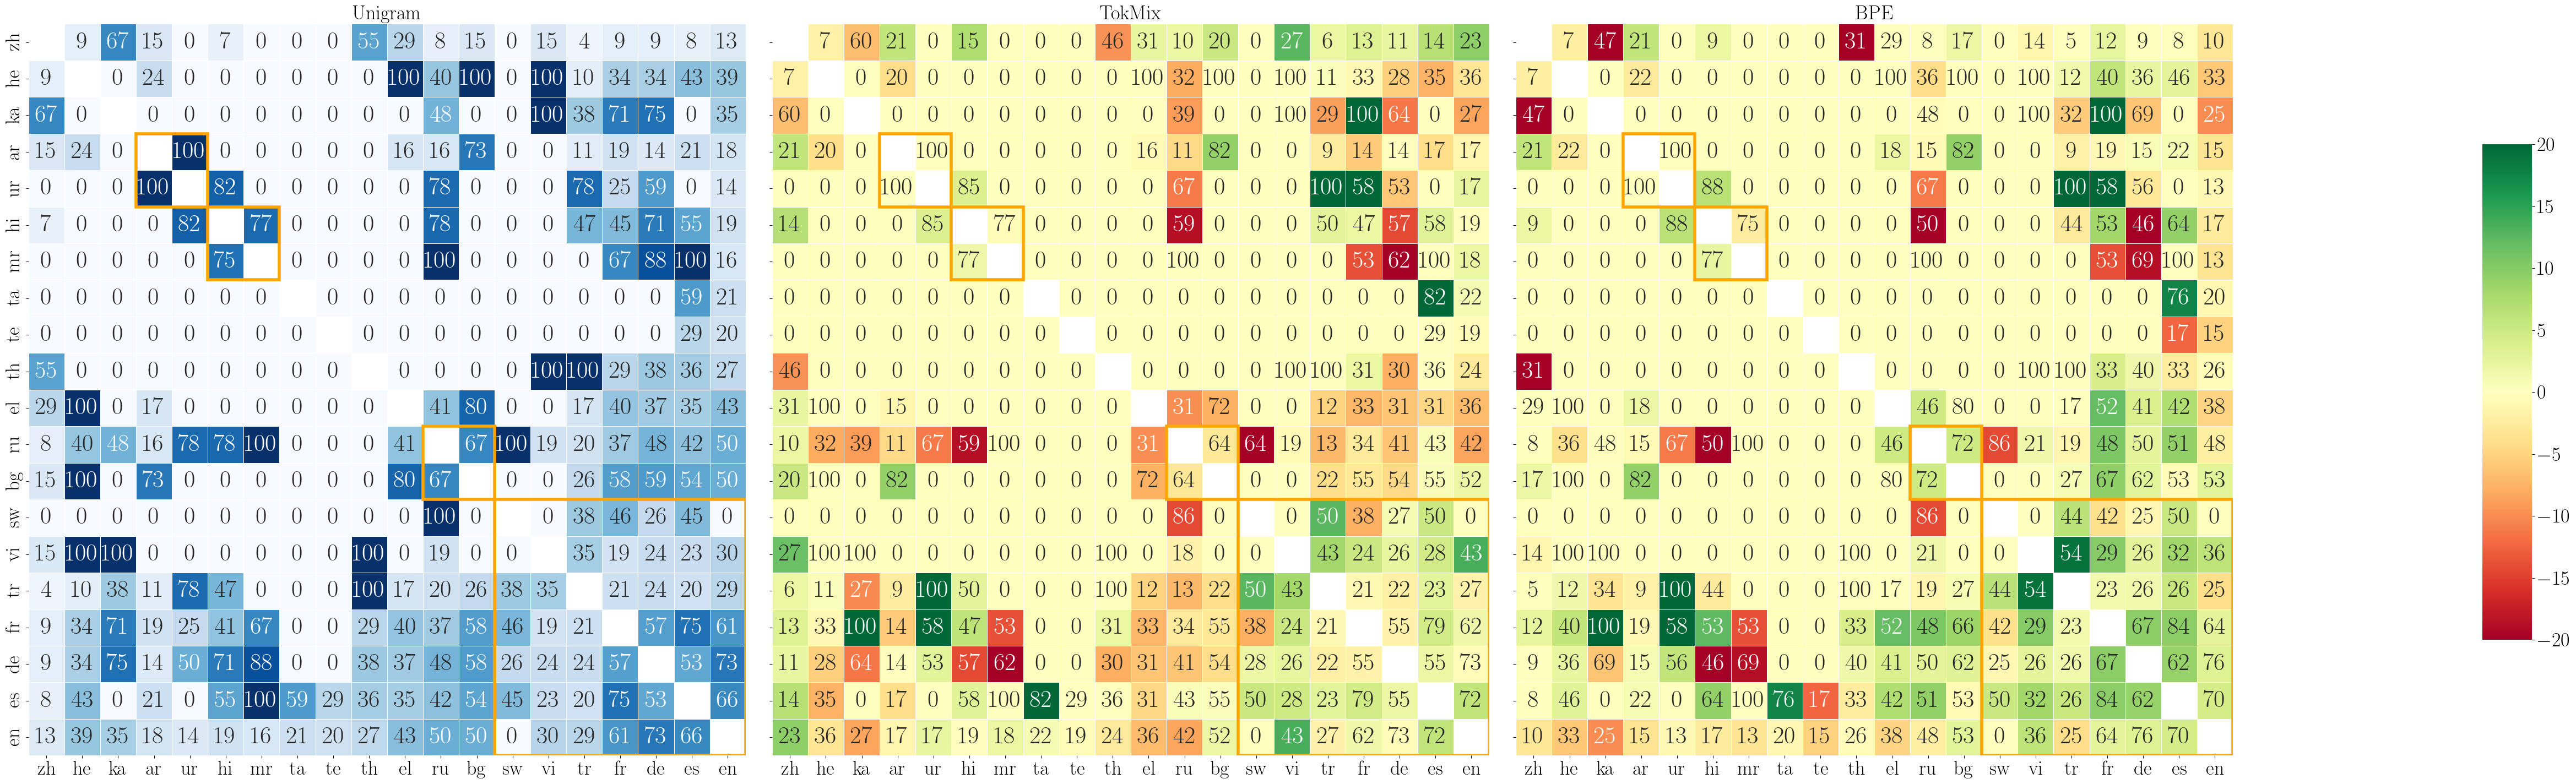

In [21]:
metric = 'accuracy'
fig, axes = plt.subplots(1, 3,figsize=(45, 15),sharex=True,sharey=True)
cbar_ax = fig.add_axes([1.01, .2, .02, .6])
axes = axes.ravel()
for t_id, tokenization in enumerate(tokenization_types):
    mask = np.eye(len(languages), dtype='bool')
    res = np.zeros_like(mask, dtype=np.float)
    for idx, lang1 in enumerate(languages_by_script):
        for jdx, lang2 in enumerate(languages_by_script):
            res[idx, jdx] = tatoeba_results[tokenization][metric][lang1][lang2] * 100

    if t_id== 0:
        res_base = res
        sns.heatmap(res, mask=mask,fmt='.0f', annot=True, linewidths=.5, ax=axes[t_id],
                    cmap="Blues", cbar=False)
    else:
        sns.heatmap(res - res_base,fmt='.0f', mask=mask, annot=res, linewidths=.5,
                    ax=axes[t_id], cmap='RdYlGn', vmin=-20, vmax=20,
                    cbar= t_id == 1,
                    cbar_ax = None if (t_id!=1) else cbar_ax)
        
    axes[t_id].add_patch(patches.Rectangle(
         (3, 3), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (5, 5), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (11, 11), 2.0, 2.0,
         edgecolor='orange',fill=False, lw=4
     ) )
    axes[t_id].add_patch(patches.Rectangle(
         (13, 13), 7.0, 7.0,
         edgecolor='orange',fill=False, lw=4
     ) )

    axes[t_id].set_xticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_yticks(np.arange(len(languages_by_script)) + 0.5, labels=languages_by_script)
    axes[t_id].set_title(f"{name_map[tokenization]}")


# fig.suptitle("Tatoeba Accuracy")

fig.tight_layout(rect=[0, 0,0.92, 1])
fig.savefig(os.path.join(FIGURE_DIR, "Tatoeba_Acc_transfer_20L.pdf"), dpi=300)
fig.show()

## Cross-lingual transfer (aggregates)

In [22]:
def update_tables(results, stds, task, metric, languages, metric_new=None):
    global X_trans_results
    global X_trans_stds
    
    global X_lang_results
    global X_lang_stds
    if not metric_new:
        metric_new = metric
        
    n_lang_pairs = len(languages) * (len(languages) - 1)
    n_lang_pairs_ss = len(set(itertools.permutations(languages,2)).intersection(set(same_script)))
        
    for tokenization in tokenization_types:
    
        est = {'task': task, 'metric': metric, 'diff-script': 0., 'same-script': 0., 'all': 0.,
                    'tokenizer': tokenization} 
        std = {'task': task, 'metric': metric, 'diff-script': 0., 'same-script': 0., 'all': 0.,
                    'tokenizer': tokenization} 

        for lang1, lang2 in itertools.product(languages, languages):
            if lang1 != lang2:


                est['all'] += results[tokenization][metric][lang1][lang2] / n_lang_pairs
                std['all'] += stds[tokenization][metric][lang1][lang2] / n_lang_pairs
                if (lang1, lang2) in same_script:
                    est['same-script'] += results[tokenization][metric][lang1][lang2] / n_lang_pairs_ss
                    std['same-script'] += stds[tokenization][metric][lang1][lang2] / n_lang_pairs_ss
                else:
                    est['diff-script'] += results[tokenization][metric][lang1][lang2] / (n_lang_pairs - n_lang_pairs_ss)
                    std['diff-script'] += stds[tokenization][metric][lang1][lang2] / (n_lang_pairs - n_lang_pairs_ss)
                X_trans_results = X_trans_results.append({'task': task, 'metric': metric_new, 'tokenizer': tokenization, 
                                        'src': lang1, 'tgt': lang2,
                                        'value': results[tokenization][metric][lang1][lang2]}, ignore_index=True)
                X_trans_stds = X_trans_stds.append({'task': task, 'metric': metric_new, 'tokenizer': tokenization,
                                     'src': lang1, 'tgt': lang2,
                                     'value': stds[tokenization][metric][lang1][lang2]}, ignore_index=True)
        X_lang_results = X_lang_results.append(est, ignore_index=True)
        X_lang_stds = X_lang_stds.append(std, ignore_index=True)
    

In [23]:
update_tables(pos_results, pos_stds, 'POS', 'f1-macro', languages_pos, metric_new='F1')

In [24]:
update_tables(ner_results, ner_stds, 'NER', 'f1-macro', languages, metric_new='F1')

In [25]:
update_tables(xnli_results, xnli_stds, 'XNLI', 'accuracy', languages_xnli, metric_new='Acc')

In [26]:
update_tables(tatoeba_results, tatoeba_stds, 'Tatoeba', 'accuracy', languages, metric_new='Acc')

# Correlation Analysis

In [27]:
X_lang_results

task    metric         tokenizer  diff-script  same-script       all
0   overlap       JSD  20l-multilingual     0.751956     0.583354  0.730659
1   overlap       JSD        20l-merged     0.800722     0.638196  0.780192
2   overlap       JSD           20l-bpe     0.826633     0.671931  0.807092
3       POS  f1-macro  20l-multilingual     0.233862     0.328603  0.246402
4       POS  f1-macro        20l-merged     0.292273     0.403576  0.307004
5       POS  f1-macro           20l-bpe     0.304971     0.406989  0.318474
6       NER  f1-macro  20l-multilingual     0.331789     0.506725  0.353886
7       NER  f1-macro        20l-merged     0.364888     0.536937  0.386621
8       NER  f1-macro           20l-bpe     0.366073     0.542973  0.388418
9      XNLI  accuracy  20l-multilingual     0.373194     0.374648  0.373513
10     XNLI  accuracy        20l-merged     0.377508     0.392077  0.380700
11     XNLI  accuracy           20l-bpe     0.361651     0.386916  0.367185
12  Tatoeba  accuracy  20l-multilingual     0.225929     0.388115  0.246416
13  Tatoeba  accuracy        20l-merged     0.219331     0.410278  0.243450
14  Tatoeba  accuracy           20l-bpe     0.225854     0.429904  0.251629

In [28]:
X_lang_stds

task    metric         tokenizer  diff-script  same-script       all
0   overlap       JSD  20l-multilingual     0.000000     0.000000  0.000000
1   overlap       JSD        20l-merged     0.000000     0.000000  0.000000
2   overlap       JSD           20l-bpe     0.000000     0.000000  0.000000
3       POS  f1-macro  20l-multilingual     0.005452     0.003198  0.005154
4       POS  f1-macro        20l-merged     0.005491     0.003107  0.005176
5       POS  f1-macro           20l-bpe     0.005984     0.003676  0.005679
6       NER  f1-macro  20l-multilingual     0.005309     0.005724  0.005362
7       NER  f1-macro        20l-merged     0.006224     0.004588  0.006018
8       NER  f1-macro           20l-bpe     0.005617     0.003423  0.005340
9      XNLI  accuracy  20l-multilingual     0.005070     0.004137  0.004865
10     XNLI  accuracy        20l-merged     0.004707     0.004920  0.004753
11     XNLI  accuracy           20l-bpe     0.004547     0.004824  0.004608
12  Tatoeba  accuracy  20l-multilingual     0.000000     0.000000  0.000000
13  Tatoeba  accuracy        20l-merged     0.000000     0.000000  0.000000
14  Tatoeba  accuracy           20l-bpe     0.000000     0.000000  0.000000

In [29]:
def format_text(mean, std=0. ,mult=1., dec=1, with_stds=False):
    mean = round(mean * mult, dec)
    std = round(std * mult, dec)
    if dec == 0:
        mean = int(mean)
        std = int(mean)
        
    if mean is np.nan:
        return "-"

    if with_stds:
        return f"{mean} $_{{\pm{std}}}$"
    else:
        return f"{mean}"



def preprocess_table(table):
    table['metric'] = [r[1]['task'] if r[1]['task']  not in ('overlap')
              else r[1]['metric'] for r in table.iterrows()]
    table= table.drop(columns=['task'])
    
    table = table[table['metric']  != 'BPC']
    table = table.replace({'tokenizer': name_map})
    table.set_index(['metric', 'tokenizer'], inplace=True)
    return table


def textify_results(res, stds):
    for i, row in res.iterrows():
        if i[0] == 'JSD':
            res.loc[i] = [format_text(v, dec=2) for v in row]
        elif i[0] == 'Tatoeba':
            res.loc[i] = [format_text(v, mult=100) for v in row]
        else:
            res.loc[i] = [format_text(v, std=s, mult=100., with_stds=True) for v, s in zip(row, stds.loc[i])]

    return res

In [30]:
tab_res = preprocess_table(X_lang_results)
tab_std = preprocess_table(X_lang_stds)

out_X_lang = textify_results(tab_res, tab_std)
out_X_lang

diff-script       same-script               all
metric  tokenizer                                                      
JSD     Unigram                0.75              0.58              0.73
        TokMix                  0.8              0.64              0.78
        BPE                    0.83              0.67              0.81
POS     Unigram    23.4 $_{\pm0.5}$  32.9 $_{\pm0.3}$  24.6 $_{\pm0.5}$
        TokMix     29.2 $_{\pm0.5}$  40.4 $_{\pm0.3}$  30.7 $_{\pm0.5}$
        BPE        30.5 $_{\pm0.6}$  40.7 $_{\pm0.4}$  31.8 $_{\pm0.6}$
NER     Unigram    33.2 $_{\pm0.5}$  50.7 $_{\pm0.6}$  35.4 $_{\pm0.5}$
        TokMix     36.5 $_{\pm0.6}$  53.7 $_{\pm0.5}$  38.7 $_{\pm0.6}$
        BPE        36.6 $_{\pm0.6}$  54.3 $_{\pm0.3}$  38.8 $_{\pm0.5}$
XNLI    Unigram    37.3 $_{\pm0.5}$  37.5 $_{\pm0.4}$  37.4 $_{\pm0.5}$
        TokMix     37.8 $_{\pm0.5}$  39.2 $_{\pm0.5}$  38.1 $_{\pm0.5}$
        BPE        36.2 $_{\pm0.5}$  38.7 $_{\pm0.5}$  36.7 $_{\pm0.5}$
Tatoeba Unigram                22.6              38.8              24.6
        TokMix                 21.9              41.0              24.3
        BPE                    22.6              43.0              25.2

In [31]:
out_X_lang.to_latex(os.path.join(TABLE_DIR,"X_lang_20L.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                        caption="Results of evaluation for cros-languages overlaps and transfers for twenty diverse languages."
                        "We observe significant changes for different tokenization methods.",
                        label="tab:X_lang_20L")

## Cross-lingual correlation analysis

In [32]:
X_trans_results

task metric         tokenizer src tgt     value
0     overlap    JSD  20l-multilingual  ar  tr  0.794223
1     overlap    JSD  20l-multilingual  ar  zh  0.823591
2     overlap    JSD  20l-multilingual  ar  el  0.777163
3     overlap    JSD  20l-multilingual  ar  es  0.786030
4     overlap    JSD  20l-multilingual  ar  en  0.768972
...       ...    ...               ...  ..  ..       ...
4861  Tatoeba    Acc           20l-bpe  de  bg  0.615142
4862  Tatoeba    Acc           20l-bpe  de  he  0.359000
4863  Tatoeba    Acc           20l-bpe  de  ka  0.687500
4864  Tatoeba    Acc           20l-bpe  de  vi  0.264339
4865  Tatoeba    Acc           20l-bpe  de  fr  0.665000

[4866 rows x 6 columns]